# Sporulation

In [2]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [11]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

<Solution 0.12 at 0x7fa3ed47f438>

In [12]:
with open('../../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [8]:
def add_transport(model,mets):
    for i in mets:
        rxn = cobrame.MEReaction('{}_transport'.format(i))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            '{}_c'.format(i):-1,
            '{}_s'.format(i):1
        })
        rxn.bounds = (-1000,1000)

### Essentiality of FS genes

In [9]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [10]:
add_transport(sporeme,['gdp','cdp'])

In [11]:
from bacillusme.analysis import sensitivity as ss

In [12]:
genes = ['BSU' + g.id.split('RNA_BSU')[1] for g in sporeme.metabolites.query(re.compile('RNA_BSU.*_s$'))]

In [ ]:
for i in range(0,int(len(genes)/100)+1):
    a,b = (i*100,i*100 + 100)
    b = min(b,len(genes))
    print(i+1,a,b)
    flux_responses = ss.all_flux_responses(sporeme,genes[a:b],NP=10,precision=1e-6, solution=sporeme.solution,
                       single_change_function='gene_knockout',growth_key='sigma')
    flux_responses.to_csv('essentiality_raw_results_FS_{}.csv'.format(i+1))

1 0 100


biomass_dilution_s response (10 threads):   0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
import os

In [19]:
flux_responses = {}
f = 'essentiality_raw_results_FS'
for i in os.listdir():
    if f not in i: continue
    if f+'.csv' == i: continue
    print(i)
    d = pd.read_csv(i,index_col=0).to_dict()
    for k,v in d.items():
        flux_responses[k] = v
flux_responses = pd.DataFrame.from_dict(flux_responses)
flux_responses.to_csv('{}.csv'.format(f))

### Essentiality of MC genes

In [24]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [25]:
from bacillusme.analysis import sensitivity as ss

In [26]:
genes = ['BSU' + g.id.split('RNA_BSU')[1] for \
         g in sporeme.metabolites.query(re.compile('RNA_BSU.*[^s]$'))]

In [ ]:
for i in range(0,int(len(genes)/100)+1):
    a,b = (i*100,i*100 + 100)
    b = min(b,len(genes))
    print(i+1,a,b)
    flux_responses = ss.all_flux_responses(sporeme,genes[a:b],NP=10,precision=1e-6, solution=sporeme.solution,
                       single_change_function='gene_knockout',growth_key='sigma')
    flux_responses.to_csv('essentiality_raw_results_MC_{}.csv'.format(i+1))

1 0 100


biomass_dilution_s response (10 threads):  15%|█▌        | 15/100 [2:40:28<5:15:05, 222.42s/it]  

In [85]:
flux_responses = {}
f = 'essentiality_raw_results_MC'
for i in os.listdir():
    if f not in i: continue
    if f+'.csv' == i: continue
    print(i)
    d = pd.read_csv(i,index_col=0).to_dict()
    for k,v in d.items():
        flux_responses[k] = v
flux_responses = pd.DataFrame.from_dict(flux_responses)
flux_responses.to_csv('{}.csv'.format(f))

essentiality_raw_results_MC_8.csv
essentiality_raw_results_MC_9.csv
essentiality_raw_results_MC_5.csv
essentiality_raw_results_MC_1.csv
essentiality_raw_results_MC_2.csv
essentiality_raw_results_MC_10.csv
essentiality_raw_results_MC_3.csv
essentiality_raw_results_MC_4.csv
essentiality_raw_results_MC_6.csv
essentiality_raw_results_MC_7.csv
essentiality_raw_results_MC_11.csv


### Essentiality

In [3]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [4]:
FS_df = pd.read_csv('essentiality_raw_results_FS.csv',index_col=0)
MC_df = pd.read_csv('essentiality_raw_results_MC.csv',index_col=0)
VG_df = pd.read_csv('../essentiality/essentiality_raw_me_results.csv',index_col=0)

In [87]:
# df = pd.read_csv('../essentiality/essentiality_raw_me_results_eco.csv',index_col=0)

In [6]:
def get_binary_essentiality(df,threshold = 1e-3,obj = 'biomass_dilution'):
    d = {}
    for g,row in df.T.iterrows():
        d[g.split('_s')[0]] = 1 if row[obj] < threshold else 0
    return d
def get_comparison(l,annotation=[],names=[]):
    d = {}
    for i in l[0]:
        if any(i not in di for di in l):
            continue
        v = [di[i] for di in l]
        if not names:
            names = range(len(l))
        d[i] = {ni:vi for ni,vi in zip(names,v)}
        if isinstance(annotation,pd.DataFrame):
            p = '{}-MONOMER'.format(i)
            if p in annotation.index:
                if i in bsub.genes:
                    model_annotation = [r.subsystem for r in bsub.genes.get_by_id(i).reactions]
                d[i]['annotation'] = annotation.loc[p]['name']
                d[i]['model_annotation'] = ','.join(model_annotation)
    return pd.DataFrame.from_dict(d).T

In [50]:
FS_es = get_binary_essentiality(FS_df,obj = 'biomass_dilution_s')
VG_es = get_binary_essentiality(VG_df,obj = 'biomass_dilution')
MC_es = get_binary_essentiality(MC_df,obj = 'biomass_dilution_s')
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()

In [52]:
# 
d = {}
for r in sporeme.reactions.query('^translation_BSU.*_s$'):
    g = r.id.split('translation_')[1].split('_s')[0]
    d[g] = {
        'name' : locus_to_name[g],
        'FS_flux' : sporeme.solution.x_dict['translation_{}_s'.format(g)],
        'FS_essential' : bool(FS_es[g]),
        'MC_flux' : sporeme.solution.x_dict['translation_{}'.format(g)],
        'MC_essential' : bool(MC_es[g])
    }
summary_df = pd.DataFrame.from_dict(d).T
summary_df.to_csv('essentiality_summary.csv')
summary_df[(summary_df['FS_flux'] > 1e-16)].to_csv('FS_proteins_summary.csv')
summary_df[(summary_df['MC_flux'] > 1e-16)].to_csv('MC_proteins_summary.csv')
summary_df.head()

,name,FS_flux,FS_essential,MC_flux,MC_essential
BSU00090,guaB,0,False,6.89715e-09,False
BSU00110,pdxS,0,False,0,False
BSU00120,pdxT,0,False,0,False
BSU00130,serS,1.77563e-09,True,2.35315e-09,True
BSU00140,dck,0,False,0,False


In [8]:
complexes = pd.read_csv('bacillus_complexes.csv',index_col=0)

In [13]:
c = get_comparison([FS_es,MC_es,VG_es],annotation=complexes,names=['FS','MC','VG'])

FS    205.0
MC    174.0
VG    311.0
dtype: float64


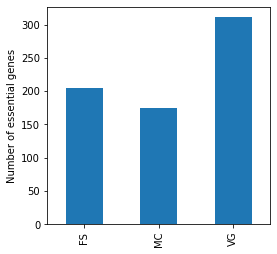

In [16]:
print(c[['FS','MC','VG']].sum())
c[['FS','MC','VG']].sum().plot.bar(figsize=(4,4))
plt.ylabel('Number of essential genes')
plt.savefig('./figures/essential_genes.svg',format='SVG')

In [92]:
from matplotlib_venn import venn3
plt.rcParams['svg.fonttype'] = 'none'

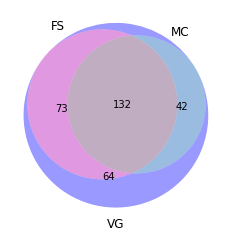

In [93]:
fs = set(c[c['FS']>0].index)
mc = set(c[c['MC']>0].index)
vg = set(c[c['VG']>0].index)
venn3([fs,mc,vg],('FS','MC','VG'))
plt.savefig('figures/venn_FS_MC_VG.svg',format='SVG')

In [94]:
c.loc['BSU19360']

FS                                                                                                     0
MC                                                                                                     0
VG                                                                                                     0
annotation          2-oxoglutarate dehydrogenase complex (dihydrolipoamide transsuccinylase, E2 subunit)
model_annotation                                                   S_Carbohydrates_and_related_molecules
Name: BSU19360, dtype: object

In [98]:
c.drop('base').to_csv('Supplementary File 1.csv')

In [81]:
c[(c.FS==1) & (c.MC==0)].drop(['FS','MC','VG'],axis=1).to_csv('annotation_FS.csv')

In [82]:
c[(c.FS==0) & (c.MC==1)].drop(['FS','MC','VG'],axis=1).to_csv('annotation_MC.csv')

In [83]:
c[(c.FS==0) & (c.MC==0) & (c.VG == 1)].drop(['FS','MC','VG'],axis=1).to_csv('annotation_VG.csv')

In [84]:
c[(c.FS==1) & (c.MC==1) & (c.VG==1)].drop(['FS','MC','VG'],axis=1).to_csv('annotation_both.csv')

In [333]:
for r in bsub.genes.get_by_id('BSU24030').reactions:
    print(r.name)
    print(r.reaction)

2-oxoisovalerate dehydrogenase (acylating; 4-methyl-2-oxopentaoate)
4mop_c + coa_c + nad_c <=> co2_c + ivcoa_c + nadh_c
2-oxoisovalerate dehydrogenase (acylating; 3-methyl-2-oxobutanoate)
3mob_c + coa_c + nad_c --> co2_c + ibcoa_c + nadh_c
2-oxoisovalerate dehydrogenase (acylating; 3-methyl-2-oxopentanoate)
3mop_c + coa_c + nad_c --> 2mbcoa_c + co2_c + nadh_c


In [343]:
flux_based_reactions(sporeme,'protein_BSU24040')

,lb,ub,rxn_flux,met_flux,reaction
formation_CPLX000-60,0,1000,0,-0,protein_BSU24030 + protein_BSU24040 + protein_BSU24050 + protein_BSU24060 --> CPLX000-60
formation_CPLX000-58,0,1000,0,-0,protein_BSU24030 + protein_BSU24040 + protein_BSU24050 + protein_BSU24060 --> CPLX000-58
formation_CPLX000-59,0,1000,0,-0,protein_BSU24030 + protein_BSU24040 + protein_BSU24050 + protein_BSU24060 --> CPLX000-59
translation_BSU24040,0,1000,0,0,10fthf_c + 40 ala__L_c + 16 arg__L_c + 6 asn__L_c + 22 asp__L_c + 3 cys__L_c + 15.0 generic_tRNA_AAA_lys__L_c + 4.0 generic_tRNA_AAC_asn__L_c + 4.0 generic_tRNA_AAG_lys__L_c + 2.0 generic_tRNA_AAU_asn__L_c + 8.0 generic_tRNA_ACA_thr__L_c + generic_tRNA_ACG_thr__L_c + generic_tRNA_ACU_thr__L_c + 5.0 generic_tRNA_AGA_arg__L_c + 4.0 generic_tRNA_AGC_ser__L_c + generic_tRNA_AGG_arg__L_c + 2.0 generic_tRNA_AUA_ile__L_c + 11.0 generic_tRNA_AUC_ile__L_c + 14.0 generic_tRNA_AUG_met__L_c + 11.0 generic_tRNA_AUU_ile__L_c + 4.0 generic_tRNA_CAA_gln__L_c + 3.0 generic_tRNA_CAC_his__L_c + 2.0 generic_tRNA_CAG_gln__L_c + 3.0 generic_tRNA_CAU_his__L_c + 4.0 generic_tRNA_CCA_pro__L_c + 2.0 generic_tRNA_CCC_pro__L_c + 9.0 generic_tRNA_CCG_pro__L_c + 3.0 generic_tRNA_CCU_pro__L_c + generic_tRNA_CGA_arg__L_c + 4.0 generic_tRNA_CGC_arg__L_c + 2.0 generic_tRNA_CGG_arg__L_c + 3.0 generic_tRNA_CGU_arg__L_c + 3.0 generic_tRNA_CUC_leu__L_c + 7.0 generic_tRNA_CUG_leu__L_c + 5.0 generic_tRNA_CUU_leu__L_c + 22.0 generic_tRNA_GAA_glu__L_c + 9.0 generic_tRNA_GAC_asp__L_c + 5.0 generic_tRNA_GAG_glu__L_c + 13.0 generic_tRNA_GAU_asp__L_c + 11.0 generic_tRNA_GCA_ala__L_c + 6.0 generic_tRNA_GCC_ala__L_c + 15.0 generic_tRNA_GCG_ala__L_c + 8.0 generic_tRNA_GCU_ala__L_c + 9.0 generic_tRNA_GGA_gly_c + 9.0 generic_tRNA_GGC_gly_c + 3.0 generic_tRNA_GGG_gly_c + 3.0 generic_tRNA_GGU_gly_c + 4.0 generic_tRNA_GUA_val__L_c + 11.0 generic_tRNA_GUC_val__L_c + 7.0 generic_tRNA_GUG_val__L_c + 6.0 generic_tRNA_GUU_val__L_c + generic_tRNA_START_met__L_c + 7.0 generic_tRNA_UAC_tyr__L_c + 6.0 generic_tRNA_UAU_tyr__L_c + 5.0 generic_tRNA_UCA_ser__L_c + 2.0 generic_tRNA_UCC_ser__L_c + 4.0 generic_tRNA_UCU_ser__L_c + generic_tRNA_UGG_trp__L_c + 3.0 generic_tRNA_UGU_cys__L_c + 5.0 generic_tRNA_UUA_leu__L_c + 5.0 generic_tRNA_UUC_phe__L_c + 2.0 generic_tRNA_UUG_leu__L_c + 7.0 generic_tRNA_UUU_phe__L_c + 6 gln__L_c + 27 glu__L_c + 24 gly_c + 654.0 gtp_c + 6 his__L_c + 24 ile__L_c + 22 leu__L_c + 19 lys__L_c + 15 met__L_c + 12 phe__L_c + 18 pro__L_c + 15 ser__L_c + 10 thr__L_c + trp__L_c + 13 tyr__L_c + 28 val__L_c --> -0.00139316239316239*sigma BSU01120-MONOMER + -4.27350427350427e-6*sigma BSU01390-MONOMER + -4.27350427350427e-6*sigma BSU15720-MONOMER + -4.27350427350427e-6*sigma BSU15730-MONOMER + -0.00139316239316239*sigma BSU16500-MONOMER + -4.27350427350427e-6*sigma BSU16520-MONOMER + -8.54700854700855e-6*sigma BSU16630-MONOMER + -4.27350427350427e-6*sigma BSU28870-MONOMER + -4.27350427350427e-6*sigma BSU35290-MONOMER + -0.000498399634202103*sigma - 0.000195123456790123 - 0.00598079561042524*(sigma + 0.3915)/sigma RNA_BSU24040 + -2.55589556001079e-8*sigma - 1.00063311174422e-8 RNA_degradosome + 1.469780521262*(sigma + 0.3915)/sigma adp_c + 326.0 + 1.35764060356653*(sigma + 0.3915)/sigma amp_c + -326.0 - 1.469780521262*(sigma + 0.3915)/sigma atp_c + 1.57294924554184*(sigma + 0.3915)/sigma cmp_c + for_c + 654.0 gdp_c + -4.27350427350427e-6*sigma generic_RF + -0.00139316239316239*sigma generic_Tuf + 1.279890260631*(sigma + 0.3915)/sigma gmp_c + -655.0 - 1.469780521262*(sigma + 0.3915)/sigma h2o_c + 980.0 + 1.469780521262*(sigma + 0.3915)/sigma h_c + -1.8755836354434*(sigma + 0.3915)/sigma mRNA_biomass + 654.0 + 1.469780521262*(sigma + 0.3915)/sigma pi_c + 326.0 ppi_c + protein_BSU24040 + 35.842841899999996 protein_biomass + -0.0046880752466162*sigma - 0.00183538145905024 ribosome + thf_c + 1.67462277091907*(sigma + 0.3915)/sigma ump_c


In [347]:
FS_df['BSU24040_s']

biomass_dilution              0.0
protein_biomass_to_biomass    0.0
mRNA_biomass_to_biomass       0.0
tRNA_biomass_to_biomass       0.0
rRNA_biomass_to_biomass       0.0
                             ... 
Demand_psetha_BS_s            0.0
Demand_t12dg_BS_s             0.0
Demand_gtca3_45_BS_s          0.0
Demand_lipo1_24_BS_s          0.0
Demand_tcam_BS_s              0.0
Name: BSU24040_s, Length: 12323, dtype: float64

In [205]:
flux_based_reactions(sporeme,'cdp_s',flux_dict=FS_df['BSU22890_s'].to_dict())

,lb,ub,rxn_flux,met_flux,reaction
RNDR3_FWD_CPLX8J2-9_s,0,999999,0.0029519,-0.0029519,cdp_s --> BSU28500-MONOMER_mod_Oxidized_s + -4.27350427350427e-6*sigma - 1.0 BSU28500-MONOMER_s + -4.27350427350427e-6*sigma CPLX8J2-9_s + dcdp_s + h2o_s
NDPK3_REV_BSU22730-MONOMER_mod_mn2_s,0,999999,0.0029519,0.0029519,adp_s + ctp_s --> -4.27350427350427e-6*sigma BSU22730-MONOMER_mod_mn2_s + atp_s + cdp_s
PPNCL_FWD_BSU15700-MONOMER_s,0,999999,1.17419e-18,1.17419e-18,4ppan_s + ctp_s + cys__L_s --> 4ppcys_s + -3.22695132810028e-6*sigma BSU15700-MONOMER_s + cdp_s + h_s + pi_s
CYTK1_REV_BSU22890-MONOMER_mod_mg2_s,0,0,0,-0,adp_s + cdp_s --> -4.27350427350427e-6*sigma BSU22890-MONOMER_mod_mg2_s + atp_s + cmp_s
NDPK3_FWD_BSU22730-MONOMER_mod_mn2_s,0,999999,0,-0,atp_s + cdp_s --> -4.27350427350427e-6*sigma BSU22730-MONOMER_mod_mn2_s + adp_s + ctp_s
BIOMASS_BS_10_FWD_CPLX_dummy_s,0,0,0,-0,0.000367 10fthf_s + 0.266902 ala__L_s + 0.00467 amp_s + 0.193021 arg__L_s + 0.147987 asn__L_s + 0.148014 asp__L_s + 105.053483 atp_s + 0.003205 ca2_s + 5e-06 cdlp_BS_s + 0.000251 cdp_s + 0.001042 cmp_s + 0.038902 ctp_s + 0.05699 cys__L_s + 0.00011 d12dg_BS_s + 0.022982 datp_s + 0.01738 dctp_s + 0.017398 dgtp_s + 0.022899 dttp_s + 0.00345 fe3_s + 0.00018 gdp_s + 0.260335 gln__L_s + 0.260378 glu__L_s + 0.408288 gly_s + 0.000503 gmp_s + 0.003624 gtca1_45_BS_s + 0.002347 gtca2_45_BS_s + 0.001819 gtca3_45_BS_s + 0.062667 gtp_s + 105.0 h2o_s + 0.081739 his__L_s + 0.269905 ile__L_s + 0.706312 k_s + 0.346445 leu__L_s + 7e-06 lipo1_24_BS_s + 6e-06 lipo2_24_BS_s + 1.8e-05 lipo3_24_BS_s + 1.5e-05 lipo4_24_BS_s + 0.323093 lys__L_s + 2.2e-05 lysylpgly_BS_s + 8.6e-05 m12dg_BS_s + 0.113326 met__L_s + 0.101714 mg2_s + 0.000266 mql7_s + 0.016164 nad_s + 0.000934 nadp_s + 0.000216 nadph_s + 0.101817 peptido_BS_s + 0.000176 pgly_BS_s + 0.175939 phe__L_s + 0.000918 ppi_s + 0.160642 pro__L_s + 0.00056 psetha_BS_s + 0.216213 ser__L_s + 6.6e-05 t12dg_BS_s + 0.003112 tcam_BS_s + 0.186317 thr__L_s + 0.054336 trp__L_s + 0.110824 tyr__L_s + 0.041501 utp_s + 0.306734 val__L_s --> -4.27350427350427e-6*sigma CPLX_dummy_s + 104.997414 adp_s + 105.0 h_s + 104.985613 pi_s
CYTK1_FWD_BSU22890-MONOMER_mod_mg2_s,0,0,0,0,atp_s + cmp_s --> -4.27350427350427e-6*sigma BSU22890-MONOMER_mod_mg2_s + adp_s + cdp_s


In [206]:
flux_based_reactions(sporeme,'ctp_s',flux_dict=FS_df['BSU22890_s'].to_dict())

,lb,ub,rxn_flux,met_flux,reaction
CTPS1_FWD_BSU37150-MONOMER_mod_mg2_s,0,0,0.048428,0.048428,atp_s + nh4_s + utp_s --> -4.27350427350427e-6*sigma BSU37150-MONOMER_mod_mg2_s + adp_s + ctp_s + 2.0 h_s + pi_s
G3PCT_FWD_BSU35740-MONOMER_s,0,999999,0.0318192,-0.0318192,ctp_s + glyc3p_s + h_s --> -4.27350427350427e-6*sigma BSU35740-MONOMER_s + cdpglyc_s + ppi_s
PHCYT_BS_FWD_BSU16540-MONOMER_mod_mg2_mod_k_s,0,999999,0.0069811,-0.0069811,0.01 12dag3p_BS_s + ctp_s + h_s --> -1.54262689436083e-5*sigma BSU16540-MONOMER_mod_mg2_mod_k_s + 0.01 cdpdag_BS_s + ppi_s
NDPK3_REV_BSU22730-MONOMER_mod_mn2_s,0,999999,0.0029519,-0.0029519,adp_s + ctp_s --> -4.27350427350427e-6*sigma BSU22730-MONOMER_mod_mn2_s + atp_s + cdp_s
transcription_TU_BSU38240_s,0,1000,4.22742e-06,-0.00175861,449 atp_s + 416 ctp_s + 360 gtp_s + 317 utp_s --> -4.27350427350427e-6*sigma BSU00550-MONOMER_s + -4.27350427350427e-6*sigma BSU01010-MONOMER_s + -4.27350427350427e-6*sigma BSU16600-MONOMER_s + -4.27350427350427e-6*sigma BSU27320-MONOMER_s + -4.27350427350427e-6*sigma CPLX8J2-30_s + RNA_BSU38240_s + 494.543165362 mRNA_biomass_s + 1542 ppi_s
...,...,...,...,...,...
transcription_TU8J2_1485_from_BSU25200-MONOMER_s,0,1000,0,-0,310.0 atp_s + 206 ctp_s + 196 gtp_s + 3.0 h2o_s + 215 utp_s --> -4.27350427350427e-6*sigma BSU00550-MONOMER_s + -4.27350427350427e-6*sigma BSU01010-MONOMER_s + -4.27350427350427e-6*sigma BSU16600-MONOMER_s + -4.27350427350427e-6*sigma BSU27320-MONOMER_s + -4.27350427350427e-6*sigma BSU37080-MONOMER_s + -4.27350427350427e-6*sigma CPLX8J2-30_s + -0.00441567943717978*sigma - 0.00172873849965588 CPLX8J2-52_s + RNA_BSU25420_s + 3.0 adp_s + 3.0 h_s + 296.48816002399997 mRNA_biomass_s + 3.0 pi_s + 924 ppi_s
transcription_TU8J2_321_from_BSU25200-MONOMER_s,0,1000,0,-0,1189.0 atp_s + 887 ctp_s + 833 gtp_s + 3.0 h2o_s + 1041 utp_s --> -4.27350427350427e-6*sigma BSU00550-MONOMER_s + -4.27350427350427e-6*sigma BSU01010-MONOMER_s + -4.27350427350427e-6*sigma BSU16600-MONOMER_s + -4.27350427350427e-6*sigma BSU27320-MONOMER_s + -4.27350427350427e-6*sigma BSU37080-MONOMER_s + -4.27350427350427e-6*sigma CPLX8J2-30_s + -0.0188622150850093*sigma - 0.00738455720578114 CPLX8J2-52_s + RNA_BSU38140_s + RNA_BSU38150_s + RNA_BSU38160_s + RNA_BSU38170_s + 3.0 adp_s + 3.0 h_s + 1250.5552831460002 mRNA_biomass_s + 3.0 pi_s + 3947 ppi_s
transcription_TU8J2_1532_from_BSU25200-MONOMER_s,0,1000,0,-0,262.0 atp_s + 256 ctp_s + 257 gtp_s + 3.0 h2o_s + 296 utp_s --> -4.27350427350427e-6*sigma BSU00550-MONOMER_s + -4.27350427350427e-6*sigma BSU01010-MONOMER_s + -4.27350427350427e-6*sigma BSU16600-MONOMER_s + -4.27350427350427e-6*sigma BSU27320-MONOMER_s + -4.27350427350427e-6*sigma BSU37080-MONOMER_s + -4.27350427350427e-6*sigma CPLX8J2-30_s + -0.00510383727154546*sigma - 0.00199815229181005 CPLX8J2-52_s + RNA_BSU32200_s + 3.0 adp_s + 3.0 h_s + 341.657165428 mRNA_biomass_s + 3.0 pi_s + 1068 ppi_s
transcription_TU_BSU15020_s,0,1000,0,-0,129 atp_s + 122 ctp_s + 82 gtp_s + 153 utp_s --> -4.27350427350427e-6*sigma BSU00550-MONOMER_s + -4.27350427350427e-6*sigma BSU01010-MONOMER_s + -4.27350427350427e-6*sigma BSU16600-MONOMER_s + -4.27350427350427e-6*sigma BSU27320-MONOMER_s + -4.27350427350427e-6*sigma CPLX8J2-30_s + RNA_BSU15020_s + 154.36005506600003 mRNA_biomass_s + 486 ppi_s
